In [18]:
import numpy as np
import pandas as pd
from scipy._lib.six import xrange
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [19]:
na_time = 0
kfold_splits = 5

# different Cs for regularisation
Cs = [1000, 100, 10, 1, 0.1, 0.01, 0.001]

# files
features_csv = "path/to/features.csv"
features_test_csv = "path/to/features_test.csv"
heroes_dict_csv = "path/to/data/dictionaries/heroes.csv"
ans_csv = "path/to/ans.csv"

In [20]:
features = pd.read_csv(features_csv, index_col="match_id")

In [21]:
def preprocessing (features, drop=False):
    hero_dict = pd.read_csv(heroes_dict_csv, index_col="id")
    
    # bag-of-words
    n_heroes = np.max(features.filter(regex=".*_hero").values)+1
    X_pick_dict = {}
    for i, match_id in enumerate(features.index):
        X_pick_dict[match_id] = np.zeros(n_heroes)
        for p in xrange(5):
            X_pick_dict[match_id][features.loc[match_id, 'r%d_hero' % (p+1)]] = 1
            X_pick_dict[match_id][features.loc[match_id, 'd%d_hero' % (p+1)]] = -1
    
    
    X_pick_df = pd.DataFrame(X_pick_dict)
    
    # replace hero numbers with names
    X_pick_df = hero_dict.join(X_pick_df).set_index('name').drop(columns=['localized_name']).dropna()
    
    X_pick_df = X_pick_df.transpose()
    
    # drop in train
    X = features
    if drop:
        X = features.drop(columns=features.columns[-6:])

    # which columns have gaps?
    counts = X.count()
    total = len(X.index)
    with_gaps = []
    for i, count in enumerate(counts):
        if count < total:
            with_gaps.append(X.columns[i])
            
    # fill gaps
    X[with_gaps] = X[with_gaps].fillna(na_time)
    
    # drop rN_hero, dN_hero columns
    todrop = list(X.filter(regex="[rd][0-9]_hero").columns)
    todrop.append('lobby_type')
    X = X.drop(todrop, axis=1)
    X = pd.concat([X, X_pick_df], axis=1)
    
    # scale 
    scaler = StandardScaler()
    scaler.fit(X)
    X_0 = X
    X = scaler.transform(X)
    
    # extract target
    if "radiant_win" in features.columns:
        y = features["radiant_win"].values
    else:
        y = None
    return X, y, X_0

In [22]:
X, y, X_0 = preprocessing(features, True)

In [23]:
# learning

kf = KFold(n_splits=kfold_splits, shuffle=True)
qualities = {}
times = {}
pred_times = {}

# for each C learn and measure time
for C in Cs:
    quality = []
    pred_time = []
    start_time = datetime.now()
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(C=C, solver='lbfgs')
        clf.fit(X_train, y_train)
        pred_start_time = datetime.now()
        y_pred = clf.predict_proba(X_train)[:,1]
        pred_time.append(datetime.now() - pred_start_time)
        quality.append(roc_auc_score(y_train, y_pred))
    pred_times[C] = np.mean(pred_time)
    times[C] = datetime.now() - start_time
    qualities[C] = np.mean(quality)

In [24]:
print("qualities:")
print(qualities)

print("\nlearn_times:")
for time in times.values():
    print(time.seconds, "secs")

print("\npred_times:")
for time in pred_times.values():
    print(time.microseconds, "microsecs")

qualities:
{0.001: 0.7542787181434518}

learn_times:
12 secs

pred_times:
48660 microsecs


In [25]:
# List of weights of features
sorted(
    zip(list(X_0.columns), clf.coef_[0]),
    key=lambda kv: abs(kv[1]),
    reverse=True)

[('queenofpain', -0.1885943330711994),
 ('r4_lh', 0.18791544305223537),
 ('r2_lh', 0.1872335207330813),
 ('r3_lh', 0.18108815643604903),
 ('d2_gold', -0.17953918104599897),
 ('r1_gold', 0.1779026141211268),
 ('r1_lh', 0.17500905935665007),
 ('r5_lh', 0.17398569658910987),
 ('r2_gold', 0.17214619652188204),
 ('d5_lh', -0.17131473938113131),
 ('d2_lh', -0.16905229568243832),
 ('d1_lh', -0.16779171381830982),
 ('d1_gold', -0.16702019777561813),
 ('d4_lh', -0.1658009359389914),
 ('d3_lh', -0.16540491617081188),
 ('r5_gold', 0.1598549842404835),
 ('d4_gold', -0.15984756187631785),
 ('d5_gold', -0.15510641249464474),
 ('r3_gold', 0.1497645593008116),
 ('r4_gold', 0.14711874371469338),
 ('spectre', 0.14524817276358293),
 ('d3_gold', -0.14332948207781304),
 ('lina', -0.13464541889171436),
 ('axe', -0.12228908622791898),
 ('earthshaker', 0.11814078779625331),
 ('d3_xp', -0.1099468540796209),
 ('omniknight', 0.10839885705628596),
 ('spirit_breaker', 0.10491080455778083),
 ('d5_xp', -0.1022364979

In [26]:
# extract test data
features_test = pd.read_csv(features_test_csv, index_col="match_id")
X_test, y_test, X_0_test = preprocessing(features_test)

In [28]:
# predict test data
y_pred = clf.predict_proba(X_test)[:,1]
ans = pd.DataFrame(index=features_test.index)
ans['radiant_win'] = y_pred

ans.to_csv(ans_csv)

0.009727336037437829 0.9943236293463338


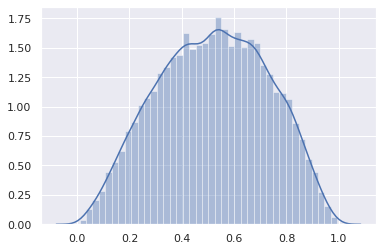

In [29]:
import seaborn as sns

# predictions distribution
print(min(y_pred), max(y_pred))
sns.set(color_codes=True)
ax = sns.distplot(y_pred)